In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, MaxPooling2D, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import random
import os
import cv2

In [2]:
os.environ["KAGGLE_USERNAME"] = "convexhulltrick"
os.environ["KAGGLE_KEY"] = "c3481a1f0799b16ed32bba929dd0a798"
!kaggle datasets download -d convexhulltrick/catdog

100% 942M/946M [00:36<00:00, 32.1MB/s]
100% 946M/946M [00:36<00:00, 26.9MB/s]


In [3]:
!unzip catdog.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/val/cat/cat.10003.jpg  
  inflating: data/val/cat/cat.10004.jpg  
  inflating: data/val/cat/cat.10005.jpg  
  inflating: data/val/cat/cat.10006.jpg  
  inflating: data/val/cat/cat.10007.jpg  
  inflating: data/val/cat/cat.10008.jpg  
  inflating: data/val/cat/cat.10009.jpg  
  inflating: data/val/cat/cat.10010.jpg  
  inflating: data/val/cat/cat.10011.jpg  
  inflating: data/val/cat/cat.10012.jpg  
  inflating: data/val/cat/cat.10013.jpg  
  inflating: data/val/cat/cat.10014.jpg  
  inflating: data/val/cat/cat.10015.jpg  
  inflating: data/val/cat/cat.10016.jpg  
  inflating: data/val/cat/cat.10017.jpg  
  inflating: data/val/cat/cat.10018.jpg  
  inflating: data/val/cat/cat.10019.jpg  
  inflating: data/val/cat/cat.10020.jpg  
  inflating: data/val/cat/cat.10021.jpg  
  inflating: data/val/cat/cat.10022.jpg  
  inflating: data/val/cat/cat.10023.jpg  
  inflating: data/val/cat/cat.10024.jpg  
  inflating: data/val/cat

In [4]:
TRAIN_DIR = '/content/data/train'
TEST_DIR = '/content/data/test'
VAL_DIR = '/content/data/val'

# TEST_CAT_DIR = os.path.join(TEST_DIR, 'cat')
# os.mkdir(TEST_CAT_DIR)
# TEST_DOG_DIR = os.path.join(TEST_DIR, 'dog')
# os.mkdir(TEST_DOG_DIR)

In [5]:
IMG_SIZE = 100
LR = 0.0001
BATCH_SIZE = 16
EPOCH = 10
adam = tf.keras.optimizers.Adam(learning_rate = LR)

MODEL_NAME = "dogs-vs-cats-classifier"

In [6]:
def get_model(): 
  pretrained_weights = '/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
  pretrained_model = tf.keras.applications.inception_v3.InceptionV3(
      include_top = False,
      weights = None, 
      input_shape = (IMG_SIZE, IMG_SIZE, 3)
  )

  pretrained_model.load_weights(pretrained_weights)

  for layer in pretrained_model.layers:
    layer.trainable = False

  last_layer = pretrained_model.get_layer("mixed7")
  last_output = last_layer.output

  x = Flatten()(last_output)
  x = Dense(512, activation = "relu")(x)
  x = Dropout(0.2)(x)
  x = Dense(1, activation = "sigmoid")(x)

  model = tf.keras.Model(pretrained_model.input, x, name = MODEL_NAME)

  model.summary()
  return model


In [7]:
train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    zoom_range = 0.3, 
    horizontal_flip = True, 
    rotation_range = 30, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size = (IMG_SIZE, IMG_SIZE), 
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'binary')
val_generator = val_datagen.flow_from_directory(VAL_DIR,
                                                  target_size = (IMG_SIZE, IMG_SIZE), 
                                                  batch_size = BATCH_SIZE, 
                                                  class_mode = 'binary')


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [8]:
model = get_model()

Model: "dogs-vs-cats-classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 49, 49, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                            

In [9]:
model.compile(loss = "binary_crossentropy", optimizer = adam, metrics = ["accuracy"])

In [10]:
%load_ext tensorboard

In [11]:
EPOCH = 20
CHECKPOINT_DIR = '/content/checkpoint'
checkpoint_callback = ModelCheckpoint(
    filepath = CHECKPOINT_DIR, 
    save_weights_only = True, 
    monitor = 'val_accuracy',
    mode = 'max', 
    save_best_only = True
)

TBOARD_DIR = '/content/tboardlogs'
tboard = TensorBoard(
    log_dir = TBOARD_DIR, 
    write_graph = True, 
    update_freq = "epoch", 
    histogram_freq = 1
)

history = model.fit(train_generator, validation_data = val_generator, epochs = EPOCH, callbacks = [checkpoint_callback])

Epoch 1/20
1250/1250 [==============================] - 141s 101ms/step - loss: 0.3326 - accuracy: 0.8495 - val_loss: 0.2146 - val_accuracy: 0.9100
Epoch 2/20
1250/1250 [==============================] - 122s 98ms/step - loss: 0.2809 - accuracy: 0.8752 - val_loss: 0.2042 - val_accuracy: 0.9128
Epoch 3/20
1250/1250 [==============================] - 128s 103ms/step - loss: 0.2695 - accuracy: 0.8809 - val_loss: 0.2079 - val_accuracy: 0.9136
Epoch 4/20
1250/1250 [==============================] - 125s 100ms/step - loss: 0.2630 - accuracy: 0.8823 - val_loss: 0.1943 - val_accuracy: 0.9180
Epoch 5/20
1250/1250 [==============================] - 111s 89ms/step - loss: 0.2567 - accuracy: 0.8882 - val_loss: 0.1818 - val_accuracy: 0.9230
Epoch 6/20
1250/1250 [==============================] - 110s 88ms/step - loss: 0.2457 - accuracy: 0.8953 - val_loss: 0.1902 - val_accuracy: 0.9228
Epoch 7/20
1250/1250 [==============================] - 111s 88ms/step - loss: 0.2412 - accuracy: 0.8938 - val_loss

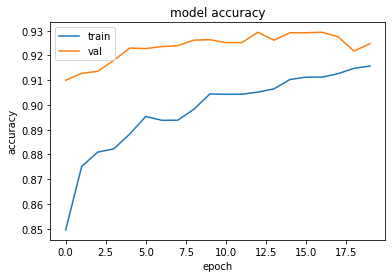

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

array([[0.]], dtype=float32)

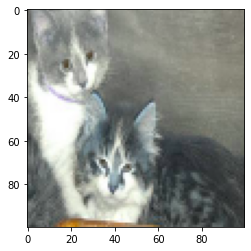

In [13]:
idx = random.randint(1, 1000)
IMG_PATH = '/content/data/test/' + str(idx) + '.jpg'
img = cv2.imread(IMG_PATH)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img)
model.predict(tf.expand_dims(img, axis=0))

In [14]:
os.mkdir(os.path.join(TEST_DIR, "catdog"))

In [15]:
%cd '/content/data/test'
!mv *.jpg '/content/data/test/catdog'

/content/data/test


In [16]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory('/content/data/test/',
                                                  target_size = (IMG_SIZE, IMG_SIZE), 
                                                  batch_size = BATCH_SIZE, 
                                                  class_mode = 'binary')


Found 12500 images belonging to 1 classes.


In [17]:
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 4.2 MB/s 


In [18]:
import pandas as pd 
import xlsxwriter

save_path = "/content/evaluate.xlsx"

workbook = xlsxwriter.Workbook(save_path)
worksheet1 = workbook.add_worksheet("summary")

def evaluate_test(threshold = 0.5):
  worksheet1.write(0, 0, "id")
  worksheet1.write(0, 1, "label")
  row = 1

  for img in os.listdir('/content/data/test/catdog'):
    IMG_PATH = '/content/data/test/catdog/' + img
    n_img = cv2.imread(IMG_PATH)
    n_img = cv2.resize(n_img, (IMG_SIZE, IMG_SIZE))
    n_img = n_img / 255

    y_hat = model.predict(tf.expand_dims(n_img, axis = 0))
    prediction = 0

    if y_hat[0] > threshold:
      prediction = 1
    else:
      prediction = 0

    worksheet1.write(row, 0, str(img).replace(".jpg", ""))
    worksheet1.write(row, 1, str(prediction))
    
    print(img + " " + str(prediction))
    row += 1

evaluate_test()
workbook.close()


Streaming output truncated to the last 5000 lines.
7094.jpg 0
9679.jpg 1
12130.jpg 0
12014.jpg 1
12480.jpg 0
2576.jpg 0
6461.jpg 1
8015.jpg 0
236.jpg 1
12447.jpg 1
5349.jpg 1
77.jpg 1
6612.jpg 0
10533.jpg 0
4458.jpg 0
1064.jpg 0
254.jpg 0
3823.jpg 1
3248.jpg 1
1169.jpg 0
3686.jpg 0
3990.jpg 0
137.jpg 1
6426.jpg 1
3961.jpg 1
128.jpg 0
5151.jpg 0
11401.jpg 0
3931.jpg 0
3459.jpg 1
1289.jpg 1
806.jpg 1
7950.jpg 0
10543.jpg 0
8409.jpg 0
5936.jpg 1
7057.jpg 0
2853.jpg 0
594.jpg 1
1580.jpg 1
11024.jpg 1
9560.jpg 1
1728.jpg 1
7915.jpg 0
7202.jpg 0
956.jpg 1
6013.jpg 0
5612.jpg 0
8034.jpg 0
10593.jpg 1
12408.jpg 0
8080.jpg 1
4566.jpg 1
9161.jpg 0
7026.jpg 1
9486.jpg 0
9959.jpg 1
3657.jpg 0
8695.jpg 1
11567.jpg 1
4228.jpg 0
4947.jpg 0
2381.jpg 1
9358.jpg 1
4756.jpg 1
11141.jpg 1
7259.jpg 1
7753.jpg 0
4568.jpg 1
4582.jpg 0
3143.jpg 1
677.jpg 0
10224.jpg 0
1990.jpg 1
4136.jpg 1
1152.jpg 0
10876.jpg 1
7593.jpg 0
10072.jpg 0
11647.jpg 1
1602.jpg 0
6449.jpg 1
3530.jpg 1
3676.jpg 1
7117.jpg 1
4076.jpg